In [ ]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FastICA
import librosa
import IPython.display as ipd
from skimage import io
from skimage.transform import resize
sns.set(rc={'figure.figsize':(15,15)})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def g(x):
    return np.tanh(x)

def g_der(x):
    return 1 - g(x) * g(x)

def center(X):
    X = np.array(X)
    mean = np.mean(X, axis=1, keepdims=True)
    return X - mean

def whiten(X):
    X = center(X)

    cov = np.cov(X)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_minus_half = np.sqrt(np.linalg.inv(D))

    X_whitened = E @ D_minus_half @ E.T @ X

    return X_whitened

def get_X(series, A):
    X = np.c_[series].T
    X = X @ A.T

    return X.T

def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(4, 1, 1)

    for x in X:
        plt.plot(x)
    plt.title("Mixtures")
    plt.ylabel('Amplitude')
    plt.legend(['Recording 1', 'Recording 2'])
    plt.subplot(4, 1, 2)

    for x in whiten(X):
        plt.plot(x)
    plt.title("Whitened signals")
    plt.ylabel('Amplitude')
    plt.legend(['Recording 1', 'Recording 2'])
    plt.subplot(4, 1, 4)

    for s in original_sources:
        plt.plot(s)
    plt.title("Real sources")
    plt.ylabel('Amplitude')
    plt.legend(['Siren sound', 'Human voice'])
    plt.subplot(4,1,3)

    for s in S:
        plt.plot(s)
    plt.title("Predicted sources")
    plt.ylabel('Amplitude')
    plt.legend(['Siren sound', 'Human voice'])
    
    fig.tight_layout()
    plt.show()

def mix_sources(mixtures, apply_noise=False):
    # for i in range(len(mixtures)):
    #     max_val = np.max(mixtures[i])
    #     if max_val > 1 or np.min(mixtures[i]) < -1:
    #         mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

def ICA(X, iterations, tolerance=1e-5):
    X = center(X)
    
    X = whiten(X)
        
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):
        
        w = np.random.rand(components_nr)
        
        for j in range(iterations):
            
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                break
                
        W[i, :] = w
        
    S = np.dot(W, X)
    
    return S, W

In [ ]:
n_samples = 20000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal
sources = [s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))/4
X = get_X(sources, A)
mean = X.mean(axis=1, keepdims=True)

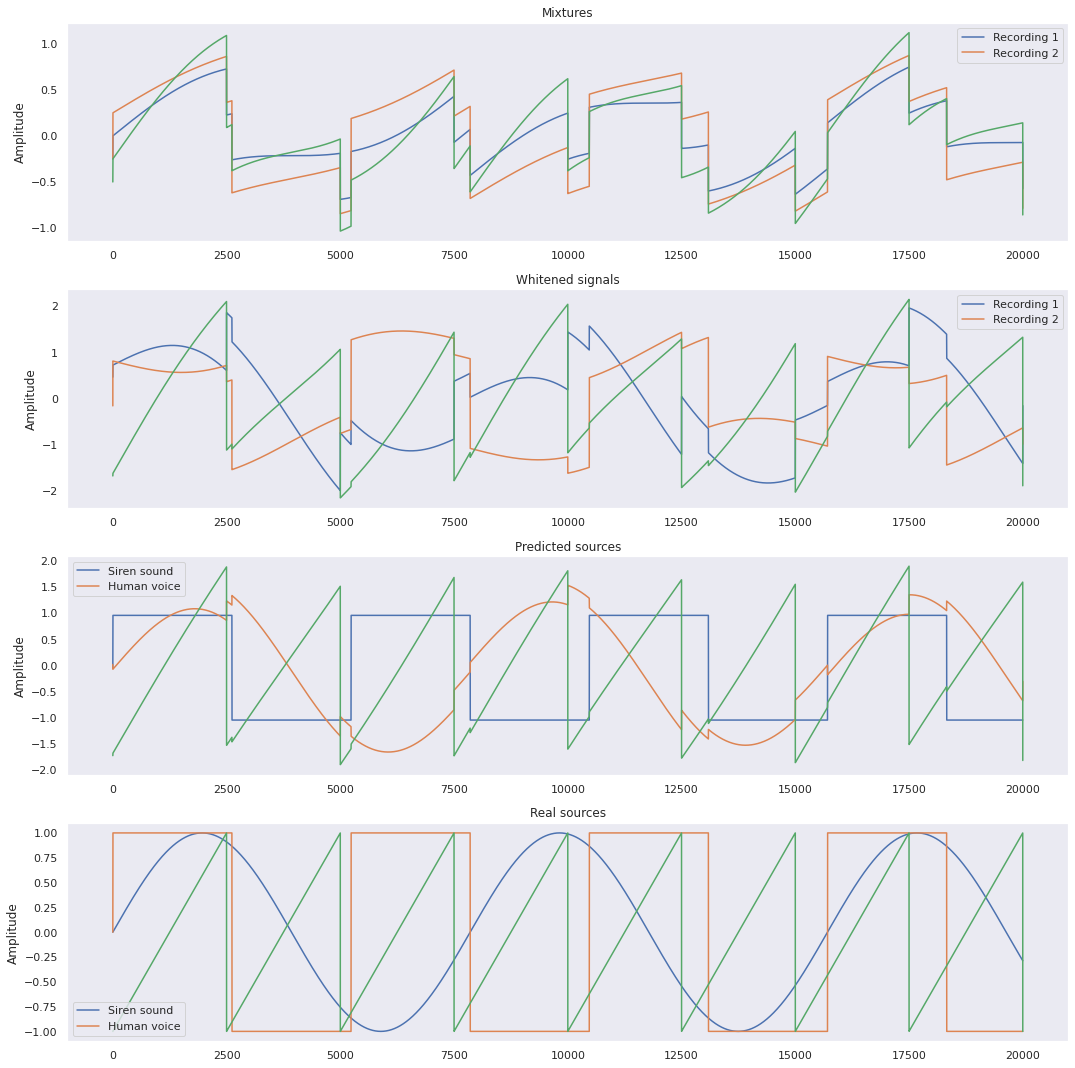

In [ ]:
S, W = ICA(X, iterations=1000)
# S = S + W @ mean
plot_mixture_sources_predictions(X, sources, S)


Play Mixed signal:



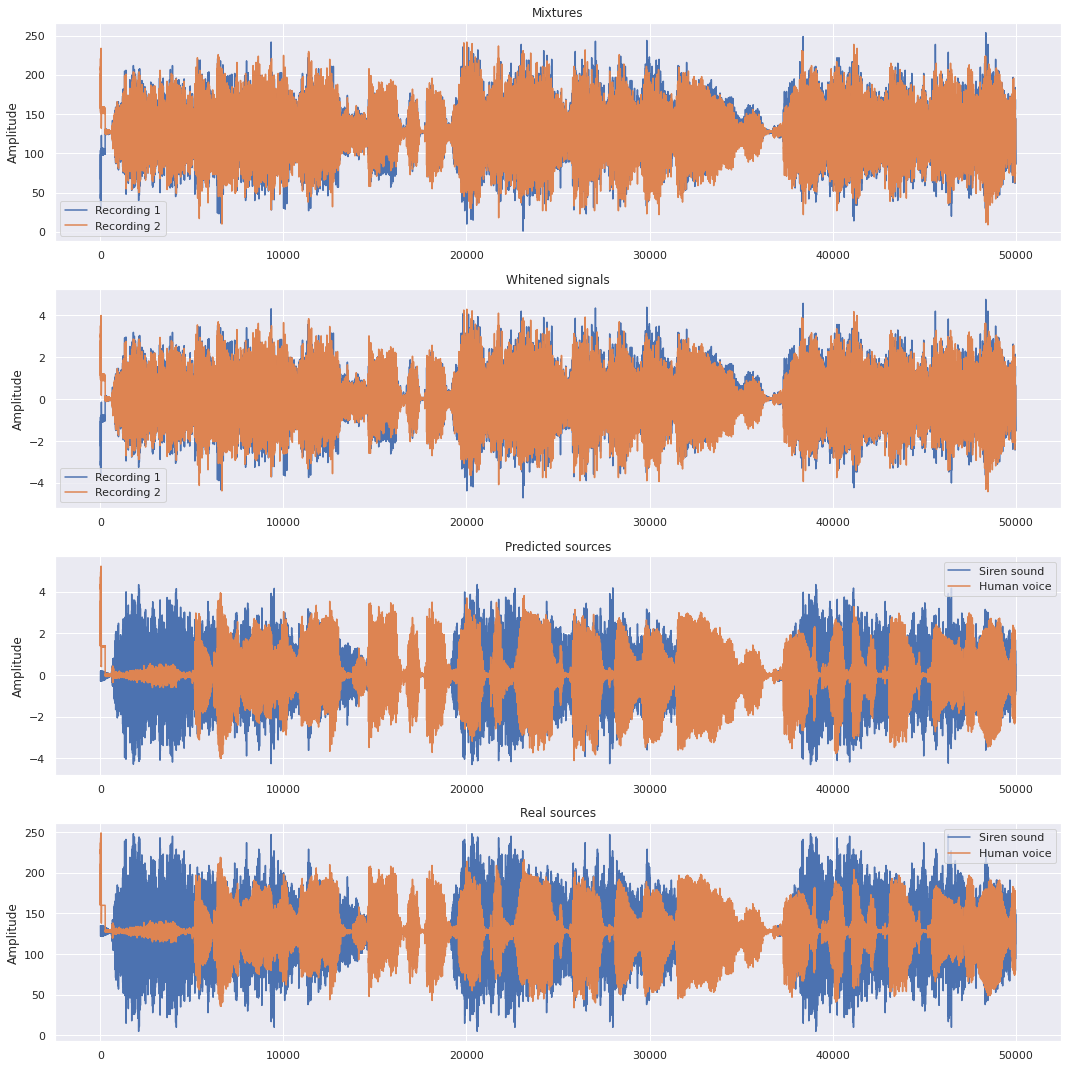


Play Separated signals:



In [ ]:
sampling_rate, mix1 = wavfile.read('/content/drive/MyDrive/ICA_files/mix1.wav')
sampling_rate, mix2 = wavfile.read('/content/drive/MyDrive/ICA_files/mix2.wav')
sampling_rate, source1 = wavfile.read('/content/drive/MyDrive/ICA_files/source1.wav')
sampling_rate, source2 = wavfile.read('/content/drive/MyDrive/ICA_files/source2.wav')

print("\nPlay Mixed signal:\n")
x, sr = librosa.load('/content/drive/MyDrive/ICA_files/mix1.wav') 
ipd.display(ipd.Audio(x, rate=sr))
print()

sources = [source1, source2]

mixes = [mix1, mix2]

X = mix_sources(mixes)
mean = X.mean(axis=1, keepdims=True)

S, W = ICA(X, iterations=1000)
S += 0
plot_mixture_sources_predictions(X, sources, S)

wavfile.write('out1_iterative.wav', sampling_rate, S[0])
wavfile.write('out2_iterative.wav', sampling_rate, S[1])

print("\nPlay Separated signals:\n")
x, sr = librosa.load('out1_iterative.wav') 
ipd.display(ipd.Audio(x, rate=sr))

x, sr = librosa.load('out2_iterative.wav') 
ipd.display(ipd.Audio(x, rate=sr))

In [ ]:
def mix_images(imgpaths, A, imgsize=(200, 200)):
    imgsarray = []
    k = len(imgpaths)

    plt.rcParams["axes.grid"] = False
    fig, axs = plt.subplots(1,2)
    for i, imgpath in enumerate(imgpaths):
        axs[i].imshow(resize(io.imread(imgpath, as_gray=True), imgsize), cmap='gray')
        axs[i].set_title('Original Image ' + str(i))
        axs[i].axis('off')


    for path in imgpaths:
        img = resize(io.imread(path, as_gray=True), imgsize).flatten()*255
        imgsarray.append(img)

    X = get_X(imgsarray, A)
    

    plt.rcParams["axes.grid"] = False
    fig, axs = plt.subplots(1,2)
    for i, img in enumerate(X):
        axs[i].imshow(img.reshape(imgsize), cmap='gray')
        axs[i].set_title('Mixed Image ' + str(i))
        axs[i].axis('off')
    return X


def Img_ICA(X, imgsize=(200, 200), iterations=1000):

    mean = np.mean(X, axis=1, keepdims=True)
    S = None
    S, W = ICA(X, iterations=iterations)
    S += W @ mean

    plt.rcParams["axes.grid"] = False
    fig, axs = plt.subplots(1,2)

    for i, img in enumerate(whiten(X)):
        axs[i].imshow(img.reshape(imgsize), cmap='gray')
        axs[i].set_title('Whitened Image ' + str(i))
        axs[i].axis('off')


    plt.rcParams["axes.grid"] = False
    fig, axs = plt.subplots(1,2)

    for i, img in enumerate(S):
        axs[i].imshow(np.abs(img.reshape(imgsize)), cmap='gray')
        axs[i].set_title('Separated Image ' + str(i))
        axs[i].axis('off')

    return S, W


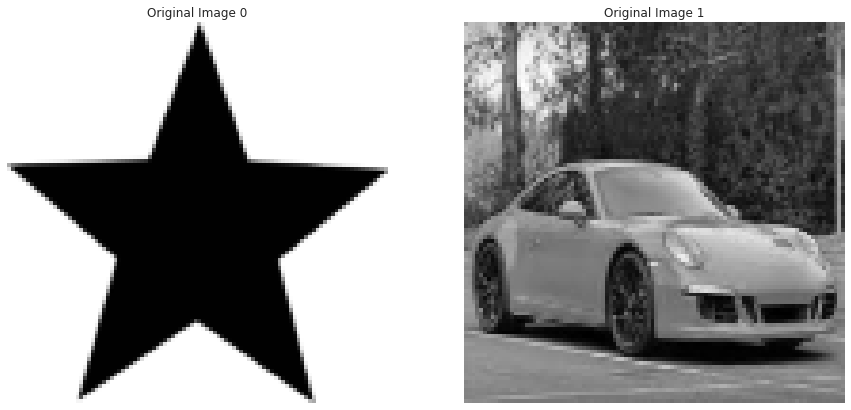

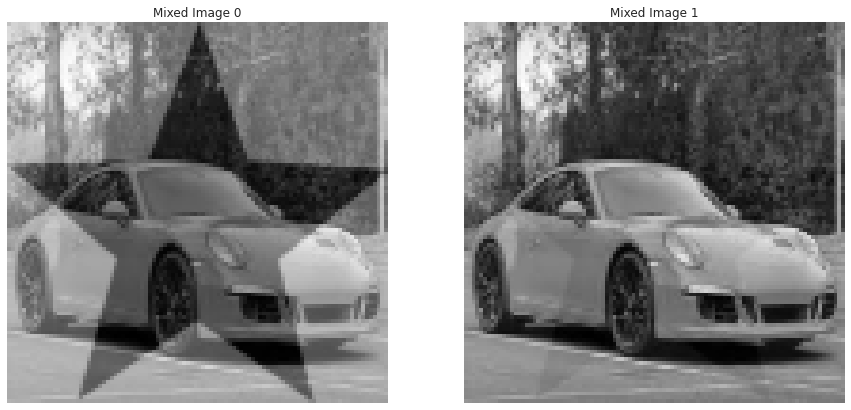

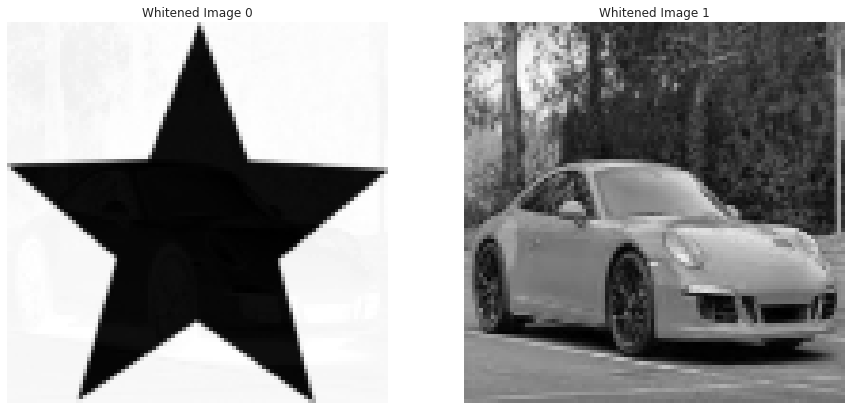

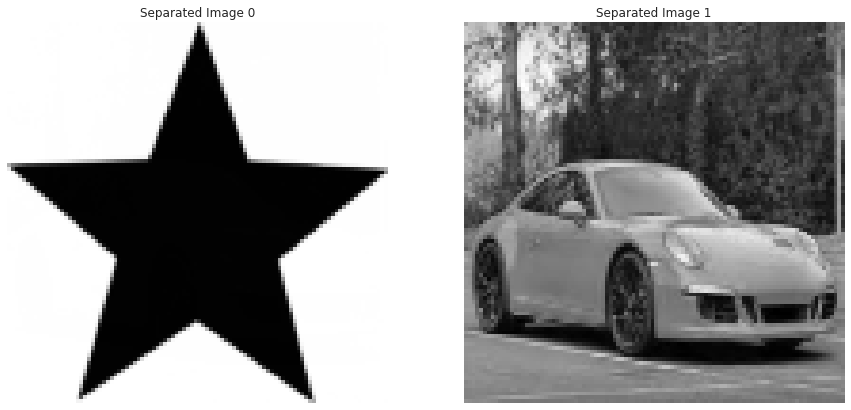

In [ ]:
imgpaths = ['/content/drive/MyDrive/ICA_files/star.png', '/content/drive/MyDrive/ICA_files/car.jpg']
A = np.array([[1, 1.1], [1, 10]])/10
imgsize=(100,100)
X = mix_images(imgpaths, A, imgsize=imgsize)
S, W = Img_ICA(X, iterations=10, imgsize=imgsize)

[[1.00000000e+00 8.54157784e-16]
 [8.54157784e-16 1.00000000e+00]]


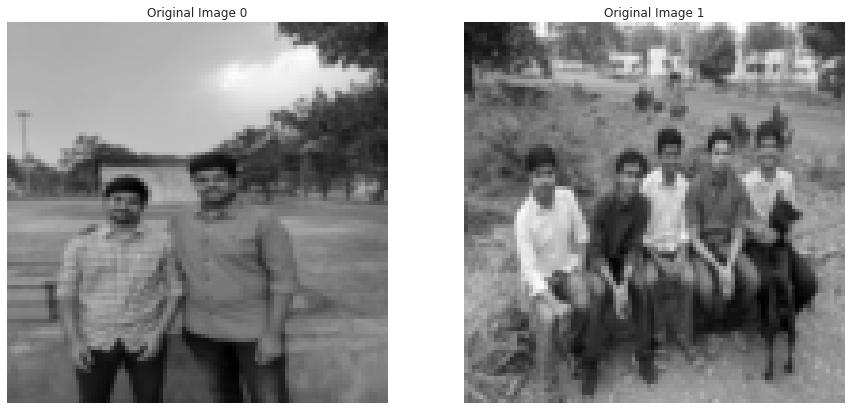

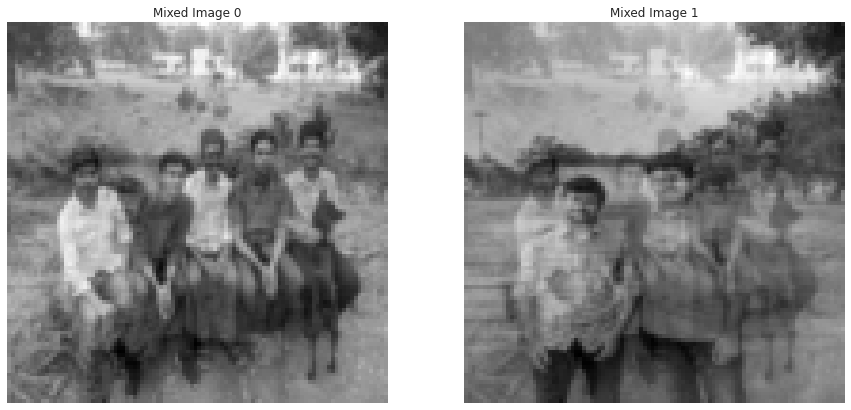

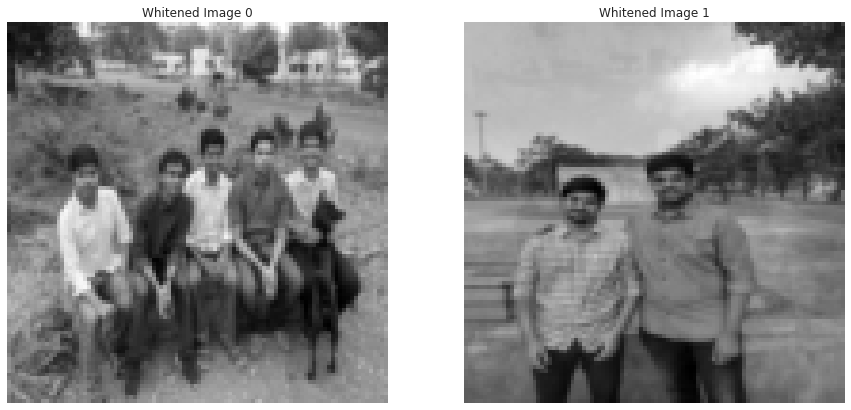

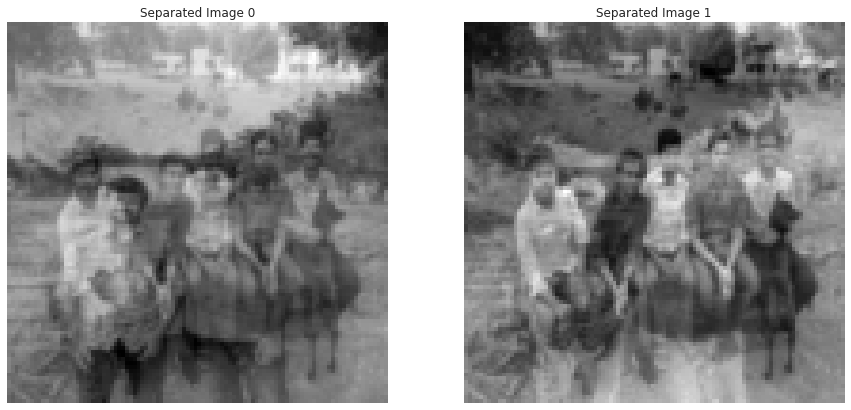

In [ ]:
imgpaths = ['/content/drive/MyDrive/ICA_files/AV_PJ.jpeg', '/content/drive/MyDrive/ICA_files/Group1.jpeg']
A = np.array([[1, 2], [2, 1]])/3
imgsize=(100,100)
X = mix_images(imgpaths, A, imgsize=imgsize)
X_whitened = whiten(X)
print(np.cov(X_whitened))

S, W = Img_ICA(X, imgsize=imgsize, iterations=10)

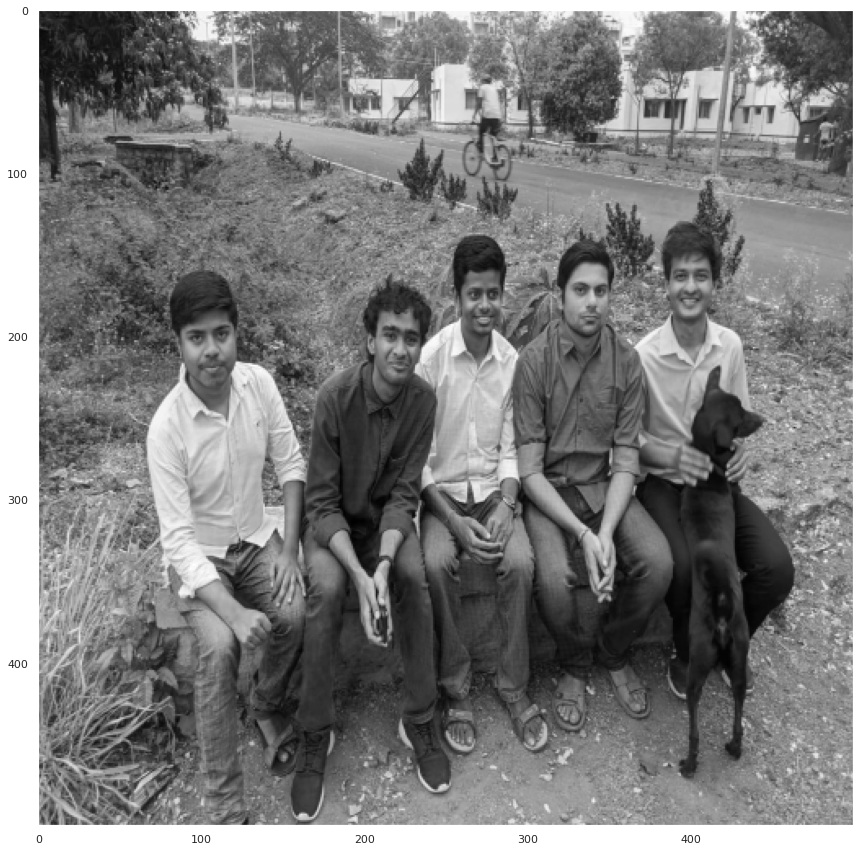

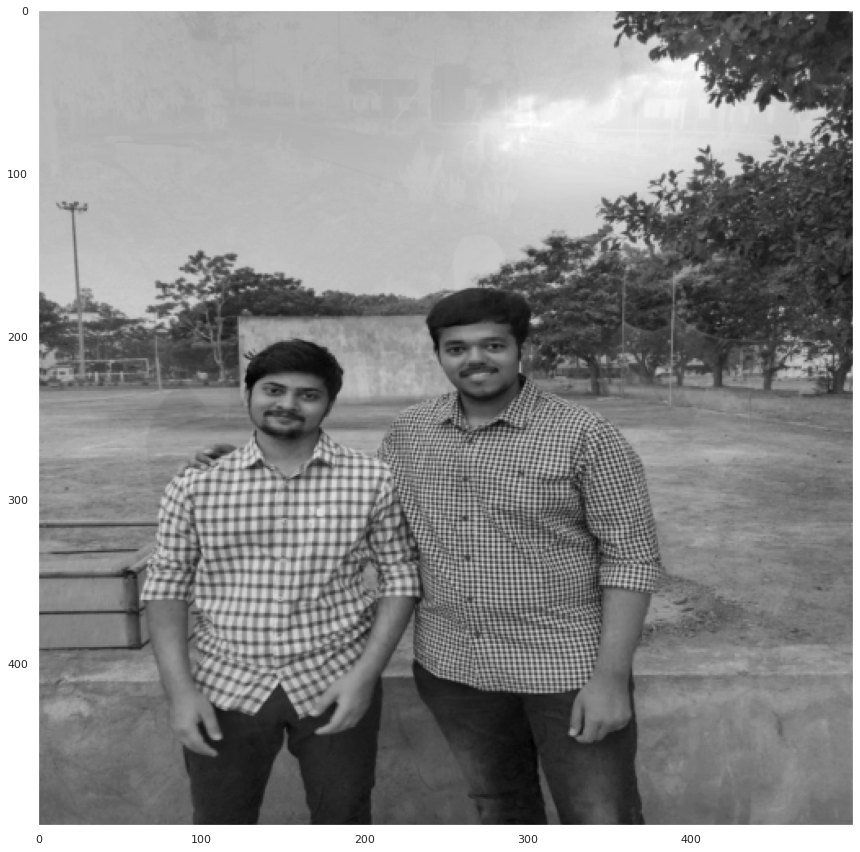

In [ ]:
plt.imshow(X_whitened[0].reshape(imgsize), cmap='gray')
plt.show()
plt.imshow(X_whitened[1].reshape(imgsize), cmap='gray')

array([[ 3.10785772e+03, -1.68846548e-13],
       [-1.68846548e-13,  2.70296943e+02]])

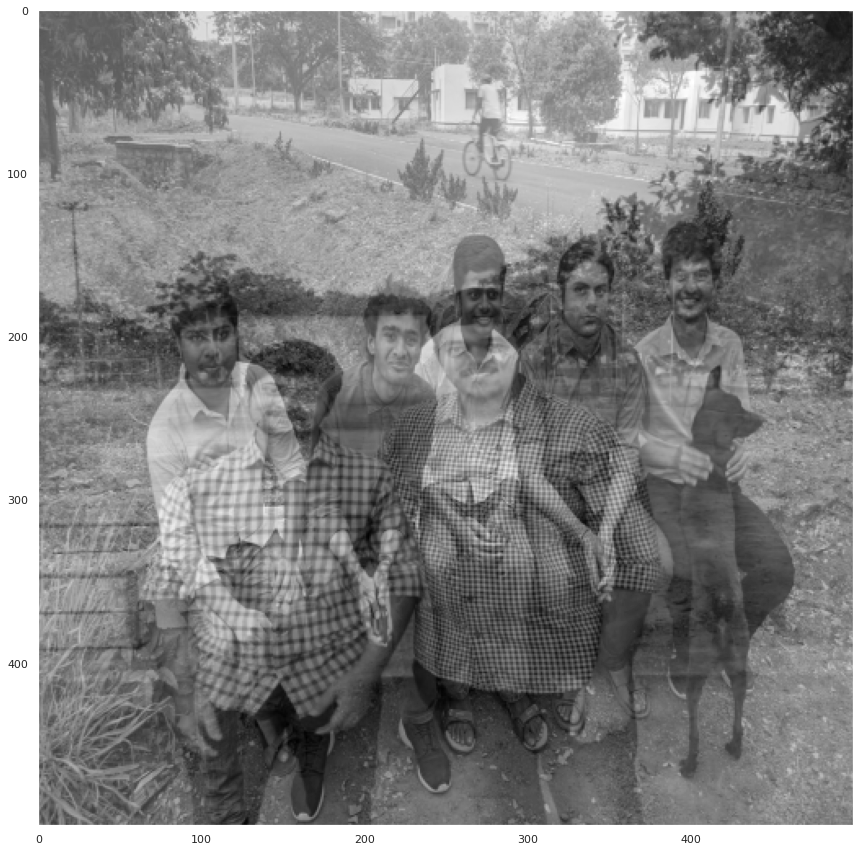

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
H = pca.fit_transform(X.T).T

plt.imshow(H[0].reshape(imgsize), cmap='gray')
np.cov(H)

In [ ]:
sampling_rate, mix1 = wavfile.read('/content/drive/MyDrive/ICA_files/Test_rec1.wav')
sampling_rate, mix2 = wavfile.read('/content/drive/MyDrive/ICA_files/Test_rec2.wav')
# sampling_rate, source1 = wavfile.read('/content/drive/MyDrive/ICA_files/source1.wav')
# sampling_rate, source2 = wavfile.read('/content/drive/MyDrive/ICA_files/source2.wav')

least_len = min(mix1.shape[0], mix2.shape[0])

filter = np.arange(0, least_len-1, 5)

mix1 = mix1[filter]
mix2 = mix2[filter]

mix1 = mix1[:,0]
mix2 = mix2[:,0]

if least_len == mix1.shape[0]:
    mix2 = mix2[:least_len]
else:
    mix1 = mix1[:least_len]

print(mix1.shape, mix2.shape)

print("\nPlay Mixed signal:\n")
x, sr = librosa.load('/content/drive/MyDrive/ICA_files/Test_rec1.wav') 
ipd.display(ipd.Audio(x, rate=sr))
print()

# sources = [source1, source2]

mixes = [mix1, mix2]

X = mix_sources(mixes)
mean = X.mean(axis=0)

S, W = ICA(X, iterations=1000)
# plot_mixture_sources_predictions(X, sources, S)

wavfile.write('out1_iterative.wav', 8000, S[0])
wavfile.write('out2_iterative.wav', 8000, S[1])

print("\nPlay Separated signals:\n")
x, sr = librosa.load('out1_iterative.wav') 
ipd.display(ipd.Audio(x, rate=sr))

x, sr = librosa.load('out2_iterative.wav') 
ipd.display(ipd.Audio(x, rate=sr))

(50803,) (50803,)

Play Mixed signal:





Play Separated signals:

